In [252]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from keras import optimizers
#from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [253]:
!python --version

Python 3.7.13


In [254]:
new_data = pd.read_csv('final_input_data_clean_monthly.csv')

In [255]:
new_data['year'] = pd.to_datetime(new_data['year'], infer_datetime_format=True)

In [256]:
new_data.index = pd.to_datetime(new_data['year'], format='%Y.%m.%d')

In [257]:
new_data.head()

,year,country,iso_code,population,gdp,cement_co2,co2,co2_including_luc,coal_co2,cumulative_cement_co2,...,share_global_cumulative_luc_co2,share_global_cumulative_oil_co2,share_global_luc_co2,share_global_oil_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,output_per_capita
year,,,,,,,,,,,,,,,,,,,,,
1949-01-31,1949-01-31,Afghanistan,AFG,7356890,9.421400e+09,0.018,0.015,8.039,0.015,0.018,...,0.14,0.0,0.16,0.0,0.129,0.0,0.0,0.0,0.0,1.992146
1949-02-28,1949-02-28,Afghanistan,AFG,7356890,9.421400e+09,0.018,0.015,8.039,0.015,0.018,...,0.14,0.0,0.16,0.0,0.129,0.0,0.0,0.0,0.0,1.992146
1949-03-31,1949-03-31,Afghanistan,AFG,7356890,9.421400e+09,0.018,0.015,8.039,0.015,0.018,...,0.14,0.0,0.16,0.0,0.129,0.0,0.0,0.0,0.0,1.992146
1949-04-30,1949-04-30,Afghanistan,AFG,7356890,9.421400e+09,0.018,0.015,8.039,0.015,0.018,...,0.14,0.0,0.16,0.0,0.129,0.0,0.0,0.0,0.0,1.992146
1949-05-31,1949-05-31,Afghanistan,AFG,7356890,9.421400e+09,0.018,0.015,8.039,0.015,0.018,...,0.14,0.0,0.16,0.0,0.129,0.0,0.0,0.0,0.0,1.992146


In [258]:
train_months = new_data.index
train_months.shape

(6943,)

In [259]:
#Variables for training
cols = ['population', 'gdp', 'cement_co2', 'co2', 'co2_including_luc', 'coal_co2', 'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_luc_co2', 'cumulative_oil_co2', 'land_use_change_co2', 'oil_co2', 'share_global_cement_co2', 'share_global_co2', 'share_global_co2_including_luc', 'share_global_coal_co2', 'share_global_cumulative_cement_co2', 'share_global_cumulative_co2', 'share_global_cumulative_co2_including_luc', 'share_global_cumulative_coal_co2', 'share_global_cumulative_luc_co2', 'share_global_cumulative_oil_co2', 'share_global_luc_co2', 'share_global_oil_co2',  'output_per_capita']

In [260]:
#New dataframe with only training data 
df_for_training = new_data[cols].astype(float)

In [261]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [262]:
trainX = []
trainY = []

n_future = 1   # Number of months we want to look into the future based on the past months.
n_past = 37  # Number of past months we want to use to predict the future.

len_a_start = n_past
len_a = 865 
len_bang_start = len_a + n_past
len_bang = 1766
len_bhu_start = len_bang + n_past
len_bhu = 2379
len_ind_start = len_bhu + n_past
len_ind = 4336
len_nep_start = len_ind + n_past
len_nep = 5189
len_pak_start = len_nep + n_past
len_pak = 6090
len_sri_start = len_pak + n_past
len_sri = 6943 

for i in range(len_a_start, len_a - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 26])
for i in range(len_bang_start, len_bang - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 26])
for i in range(len_bhu_start, len_bhu - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 26])
for i in range(len_ind_start, len_ind - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 26])
for i in range(len_nep_start, len_nep - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 26])
for i in range(len_pak_start, len_pak - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 26])
for i in range(len_sri_start, len_sri - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 26])
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (6684, 37, 27).
trainY shape == (6684, 1).


# Training the LSTM

In [263]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
#sgd = optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizers.Adam(lr=0.0001, decay=1e-6), loss='mae',metrics=['mse', 'mape',tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 37, 64)            23552     
                                                                 
 lstm_69 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_115 (Dense)           (None, 1)                 65        
                                                                 
Total params: 56,641
Trainable params: 56,641
Non-trainable params: 0
_________________________________________________________________


In [264]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.2, verbose=1, callbacks=None)

Epoch 1/10
168/168 [==============================] - 5s 19ms/step - loss: 0.3545 - mse: 0.5278 - mape: 112.0866 - root_mean_squared_error: 0.7265 - val_loss: 0.7259 - val_mse: 1.0876 - val_mape: 87.9189 - val_root_mean_squared_error: 1.0429
Epoch 2/10
168/168 [==============================] - 3s 19ms/step - loss: 0.1216 - mse: 0.0736 - mape: 32.7945 - root_mean_squared_error: 0.2713 - val_loss: 0.4083 - val_mse: 0.4817 - val_mape: 37.2636 - val_root_mean_squared_error: 0.6940
Epoch 3/10
168/168 [==============================] - 3s 19ms/step - loss: 0.0873 - mse: 0.0337 - mape: 26.0615 - root_mean_squared_error: 0.1836 - val_loss: 0.3789 - val_mse: 0.4359 - val_mape: 38.9831 - val_root_mean_squared_error: 0.6603
Epoch 4/10
168/168 [==============================] - 3s 19ms/step - loss: 0.0769 - mse: 0.0258 - mape: 25.2092 - root_mean_squared_error: 0.1606 - val_loss: 0.3449 - val_mse: 0.3921 - val_mape: 39.2503 - val_root_mean_squared_error: 0.6262
Epoch 5/10
168/168 [===============

In [265]:
for i in history.history.keys():
    print(i)
    for j in range(len(history.history[i])):
        print(history.history[i][j])
    print('\n')

loss
0.3544858992099762
0.12163595855236053
0.08732310682535172
0.07694455236196518
0.06840239465236664
0.06581567227840424
0.06446215510368347
0.06440705060958862
0.0609385222196579
0.059248186647892


mse
0.527769148349762
0.07359360158443451
0.03372093662619591
0.025793423876166344
0.017131295055150986
0.01636931113898754
0.014908895827829838
0.01913559064269066
0.01662362553179264
0.01544742751866579


mape
112.08661651611328
32.79449462890625
26.061506271362305
25.209230422973633
22.134191513061523
19.796846389770508
19.653200149536133
19.8587589263916
18.13888931274414
17.35459327697754


root_mean_squared_error
0.7264772057533264
0.2712814211845398
0.18363261222839355
0.16060331463813782
0.13088656961917877
0.12794260680675507
0.12210199236869812
0.13833145797252655
0.1289326399564743
0.1242876797914505


val_loss
0.7259438037872314
0.40831393003463745
0.3788604438304901
0.3449343740940094
0.34395089745521545
0.3533211648464203
0.331428587436676
0.3306066691875458
0.328645288944

### RESULT METRICS-

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


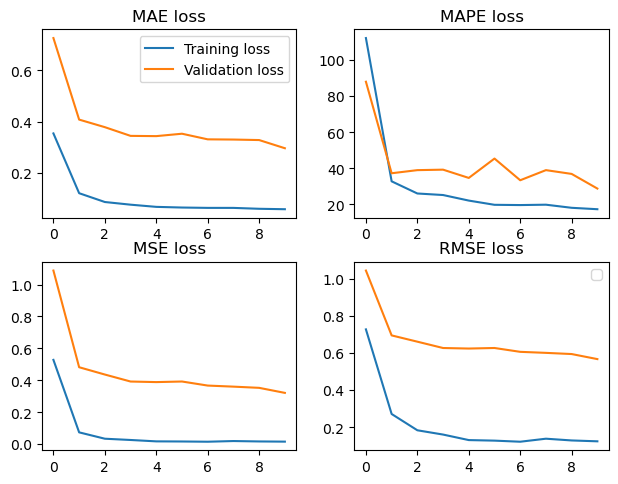

In [266]:
#Result metrics
figure, axis = plt.subplots(2, 2)
figure.tight_layout()
plt.legend()
axis[0, 0].plot(history.history['loss'], label='Training loss')
axis[0, 0].plot(history.history['val_loss'], label='Validation loss')
axis[0,0].set_title('MAE loss')
axis[1,0].set_title('MSE loss')
axis[0,1].set_title('MAPE loss')
axis[1,1].set_title('RMSE loss')
axis[1, 0].plot(history.history['mse'], label='MSE Training loss')
axis[1, 0].plot(history.history['val_mse'], label='MSE Validation loss')
axis[0,0].legend()
axis[0, 1].plot(history.history['mape'], label='MAPE Training loss')
axis[0, 1].plot(history.history['val_mape'], label='MAPE Validation loss')
axis[1, 1].plot(history.history['root_mean_squared_error'], label='RMSE Training loss')
axis[1, 1].plot(history.history['val_root_mean_squared_error'], label='RMSE Validation loss')


In [267]:
s = model.predict(trainX[0:2,:,:])
print(s)
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
print(forecast_copies.shape)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,26]
print(y_pred_future)
print(trainY[0:2])
forecast_copies = np.repeat(trainY[0:2], df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies)[:,26]
print(input_rescale)

1/1 [==============================] - 0s 174ms/step
[[-0.7697521 ]
 [-0.76961756]]
(2, 27)
[244.44196 245.33405]
[[-0.80107175]
 [-0.80107175]]
[36.7951417 36.7951417]


209/209 [==============================] - 1s 7ms/step
(6684,)
(6684,)


<AxesSubplot:>

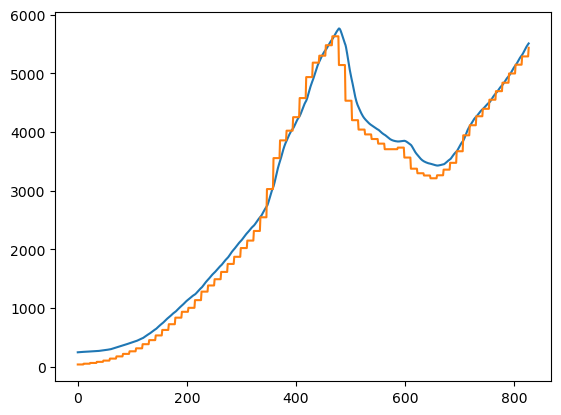

In [268]:
s = model.predict(trainX)
years = []
for i in range(6000):
    years.append(i)
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,26]
print(y_pred_future.shape)
forecast_copies = np.repeat(trainY, df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies)[:,26]
print(input_rescale.shape)
sns.lineplot(years[0:828],y_pred_future[0:828])
sns.lineplot(years[0:828],input_rescale[0:828])

In [269]:
#Forecast for the next 1 year

# Training the A-LSTM : 

In [270]:
import tensorflow as tf
import numpy as np

# Generate some dummy data
T = 37  # Sequence length
D = 27   # Number of features
N = 6930  # Number of samples

# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

# Build the model
def build_model(T, D):
    inputs = tf.keras.Input(shape=(T, D))
    x = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
    x = Attention(64)(x)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# Build and compile the model
model2 = build_model(T, D)
model2.compile(optimizer=optimizers.Adam(lr=0.0001, decay=1e-6), loss="mae",metrics=['mse', 'mape',tf.keras.metrics.RootMeanSquaredError()])
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 37, 27)]          0         
                                                                 
 lstm_70 (LSTM)              (None, 37, 64)            23552     
                                                                 
 attention_6 (Attention)     (None, 64)                4225      
                                                                 
 dense_118 (Dense)           (None, 1)                 65        
                                                                 
Total params: 27,842
Trainable params: 27,842
Non-trainable params: 0
_________________________________________________________________


In [271]:
# Train the model
attention_lstm = model2.fit(trainX, trainY, epochs=10, batch_size=32 , validation_split = 0.2,verbose = 1,callbacks=my_callbacks)

Epoch 1/10
168/168 [==============================] - 4s 13ms/step - loss: 0.3213 - mse: 0.3413 - mape: 119.1072 - root_mean_squared_error: 0.5842 - val_loss: 0.5404 - val_mse: 0.5619 - val_mape: 119.3018 - val_root_mean_squared_error: 0.7496
Epoch 2/10
168/168 [==============================] - 2s 12ms/step - loss: 0.0736 - mse: 0.0471 - mape: 26.0089 - root_mean_squared_error: 0.2170 - val_loss: 0.2844 - val_mse: 0.2363 - val_mape: 41.8046 - val_root_mean_squared_error: 0.4861
Epoch 3/10
168/168 [==============================] - 2s 12ms/step - loss: 0.0471 - mse: 0.0178 - mape: 22.5384 - root_mean_squared_error: 0.1335 - val_loss: 0.2107 - val_mse: 0.1384 - val_mape: 32.8669 - val_root_mean_squared_error: 0.3720
Epoch 4/10
168/168 [==============================] - 2s 11ms/step - loss: 0.0372 - mse: 0.0089 - mape: 20.2316 - root_mean_squared_error: 0.0943 - val_loss: 0.1670 - val_mse: 0.0872 - val_mape: 30.1037 - val_root_mean_squared_error: 0.2953
Epoch 5/10
168/168 [==============

In [272]:
for i in attention_lstm.history.keys():
    print(i)
    for j in range(len(attention_lstm.history[i])):
        print(attention_lstm.history[i][j])
    print('\n')

loss
0.32132434844970703
0.07363995164632797
0.04713132604956627
0.03718720003962517
0.02922978065907955
0.025870615616440773
0.022742148488759995
0.020530037581920624
0.019983988255262375
0.019584672525525093


mse
0.3412688970565796
0.047078926116228104
0.01781320571899414
0.008896848186850548
0.004634866025298834
0.0026441412046551704
0.0018058756832033396
0.001415499486029148
0.0012683930108323693
0.0012271682498976588


mape
119.1071548461914
26.00894546508789
22.53839874267578
20.231630325317383
18.221529006958008
16.660736083984375
15.794376373291016
14.394222259521484
13.422839164733887
12.823639869689941


root_mean_squared_error
0.5841822624206543
0.21697679162025452
0.13346612453460693
0.09432310611009598
0.06807985156774521
0.051421213895082474
0.042495597153902054
0.037623126059770584
0.0356145054101944
0.03503096103668213


val_loss
0.5404422283172607
0.2843513488769531
0.21070897579193115
0.1670084148645401
0.14747408032417297
0.1285828799009323
0.11316782981157303
0.114

In [273]:
for i in attention_lstm.history.keys():
    print(i)
    for j in range(len(attention_lstm.history[i])):
        print(attention_lstm.history[i][j])
    print('\n')

loss
0.32132434844970703
0.07363995164632797
0.04713132604956627
0.03718720003962517
0.02922978065907955
0.025870615616440773
0.022742148488759995
0.020530037581920624
0.019983988255262375
0.019584672525525093


mse
0.3412688970565796
0.047078926116228104
0.01781320571899414
0.008896848186850548
0.004634866025298834
0.0026441412046551704
0.0018058756832033396
0.001415499486029148
0.0012683930108323693
0.0012271682498976588


mape
119.1071548461914
26.00894546508789
22.53839874267578
20.231630325317383
18.221529006958008
16.660736083984375
15.794376373291016
14.394222259521484
13.422839164733887
12.823639869689941


root_mean_squared_error
0.5841822624206543
0.21697679162025452
0.13346612453460693
0.09432310611009598
0.06807985156774521
0.051421213895082474
0.042495597153902054
0.037623126059770584
0.0356145054101944
0.03503096103668213


val_loss
0.5404422283172607
0.2843513488769531
0.21070897579193115
0.1670084148645401
0.14747408032417297
0.1285828799009323
0.11316782981157303
0.114

### RESULT METRICS-  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


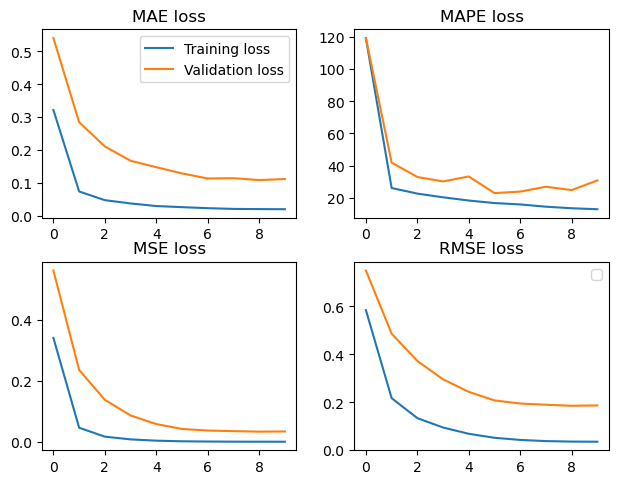

In [274]:
#Result metrics
figure, axis = plt.subplots(2, 2)
figure.tight_layout()
plt.legend()
axis[0, 0].plot(attention_lstm.history['loss'], label='Training loss')
axis[0, 0].plot(attention_lstm.history['val_loss'], label='Validation loss')
axis[0,0].set_title('MAE loss')
axis[1,0].set_title('MSE loss')
axis[0,1].set_title('MAPE loss')
axis[1,1].set_title('RMSE loss')
axis[1, 0].plot(attention_lstm.history['mse'], label='MSE Training loss')
axis[1, 0].plot(attention_lstm.history['val_mse'], label='MSE Validation loss')
axis[0,0].legend()
axis[0, 1].plot(attention_lstm.history['mape'], label='MAPE Training loss')
axis[0, 1].plot(attention_lstm.history['val_mape'], label='MAPE Validation loss')
axis[1, 1].plot(attention_lstm.history['root_mean_squared_error'], label='RMSE Training loss')
axis[1, 1].plot(attention_lstm.history['val_root_mean_squared_error'], label='RMSE Validation loss')


In [275]:
s = model2.predict(trainX[0:2,:,:])
print(s)
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
print(forecast_copies.shape)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,26]
print(y_pred_future)
print(trainY[0:2])
forecast_copies = np.repeat(trainY[0:2], df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies)[:,26]
print(input_rescale)

1/1 [==============================] - 0s 286ms/step
[[-0.78857285]
 [-0.7884382 ]]
(2, 27)
[119.66169  120.554756]
[[-0.80107175]
 [-0.80107175]]
[36.7951417 36.7951417]


209/209 [==============================] - 1s 4ms/step
(6684,)
(6684,)


<AxesSubplot:>

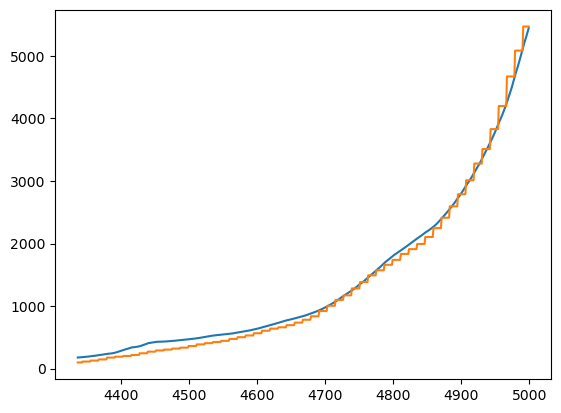

In [276]:
s = model2.predict(trainX)
years = []
for i in range(6852):
    years.append(i)
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,26]
print(y_pred_future.shape)
forecast_copies = np.repeat(trainY, df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies)[:,26]
print(input_rescale.shape)
sns.lineplot(years[4336:5000],y_pred_future[4336:5000])
sns.lineplot(years[4336:5000],input_rescale[4336:5000])

#Forecast (TBD)

# Comparision between LSTM and A-LSTM

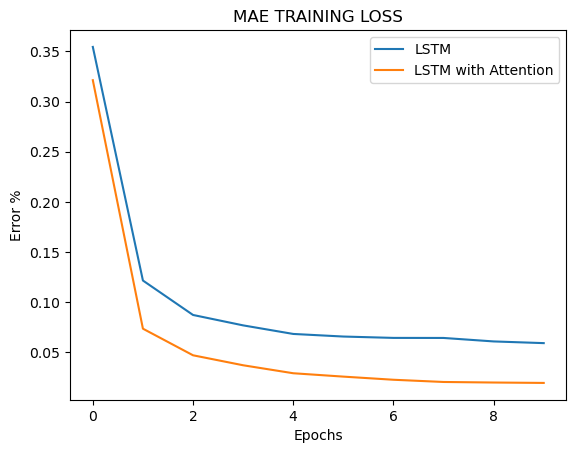

In [277]:
#Comparision between lstm and lstm with attention

plt.plot(history.history['loss'], label='LSTM')
plt.plot(attention_lstm.history['loss'], label='LSTM with Attention')
plt.title("MAE TRAINING LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()


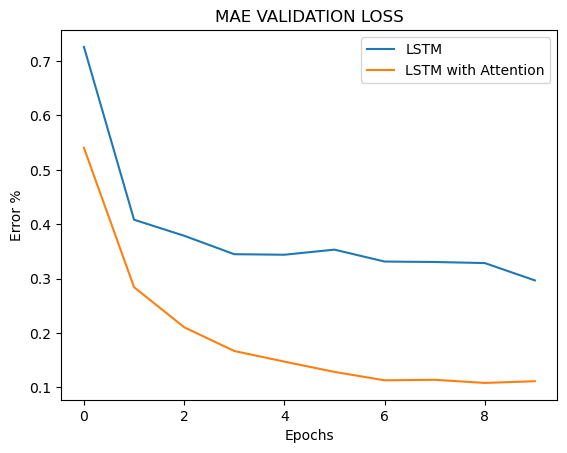

In [278]:
plt.plot(history.history['val_loss'], label='LSTM')
plt.plot(attention_lstm.history['val_loss'], label='LSTM with Attention')
plt.title("MAE VALIDATION LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

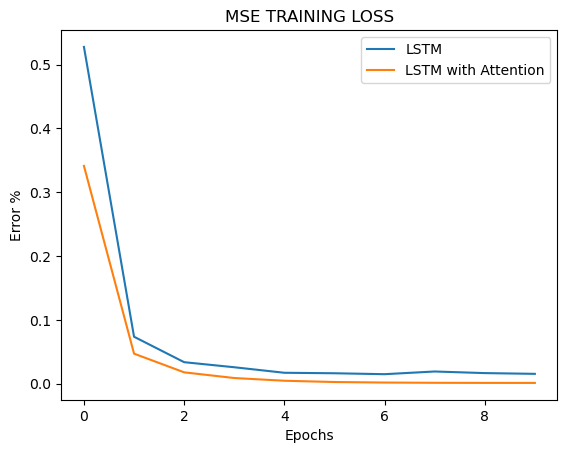

In [279]:
plt.plot(history.history['mse'], label='LSTM')
plt.plot(attention_lstm.history['mse'], label='LSTM with Attention')
plt.title("MSE TRAINING LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

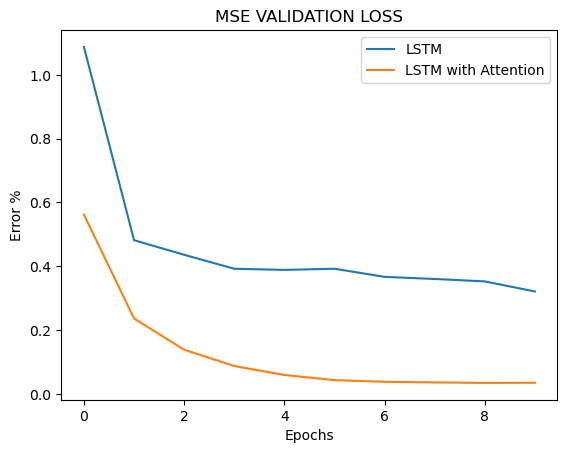

In [280]:
plt.plot(history.history['val_mse'], label='LSTM')
plt.plot(attention_lstm.history['val_mse'], label='LSTM with Attention')
plt.title("MSE VALIDATION LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

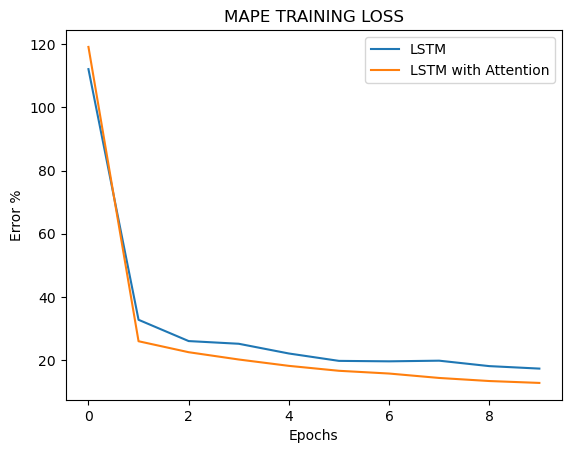

In [281]:
plt.plot(history.history['mape'], label='LSTM')
plt.plot(attention_lstm.history['mape'], label='LSTM with Attention')
plt.title("MAPE TRAINING LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

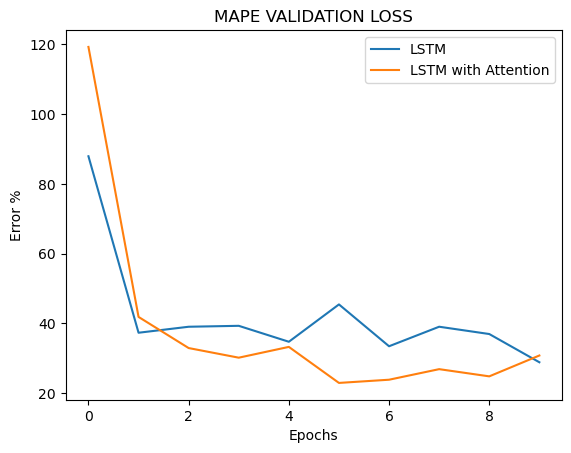

In [282]:
plt.plot(history.history['val_mape'], label='LSTM')
plt.plot(attention_lstm.history['val_mape'], label='LSTM with Attention')
plt.title("MAPE VALIDATION LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

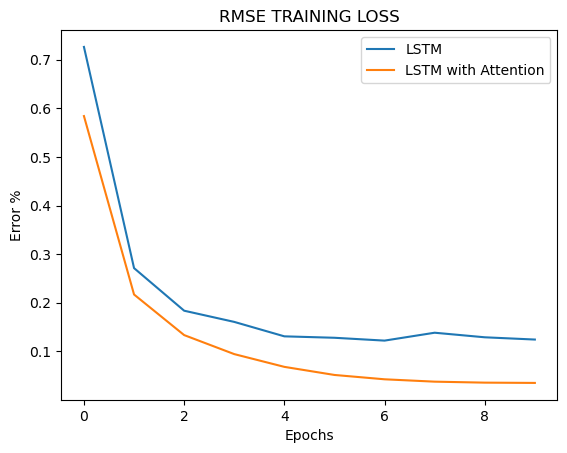

In [283]:
plt.plot(history.history['root_mean_squared_error'], label='LSTM')
plt.plot(attention_lstm.history['root_mean_squared_error'], label='LSTM with Attention')
plt.title("RMSE TRAINING LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

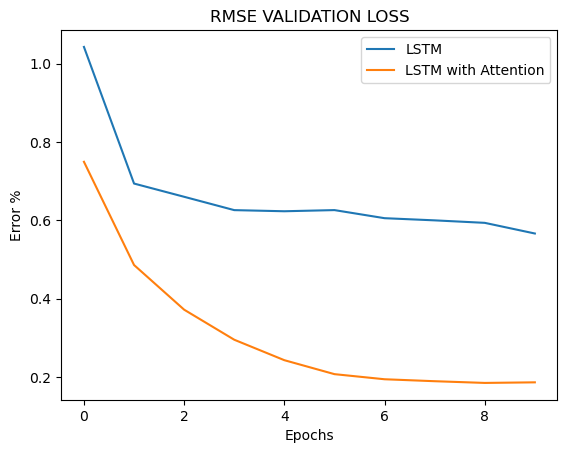

In [284]:
plt.plot(history.history['val_root_mean_squared_error'], label='LSTM')
plt.plot(attention_lstm.history['val_root_mean_squared_error'], label='LSTM with Attention')
plt.title("RMSE VALIDATION LOSS")
plt.xlabel("Epochs")
plt.ylabel("Error %")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


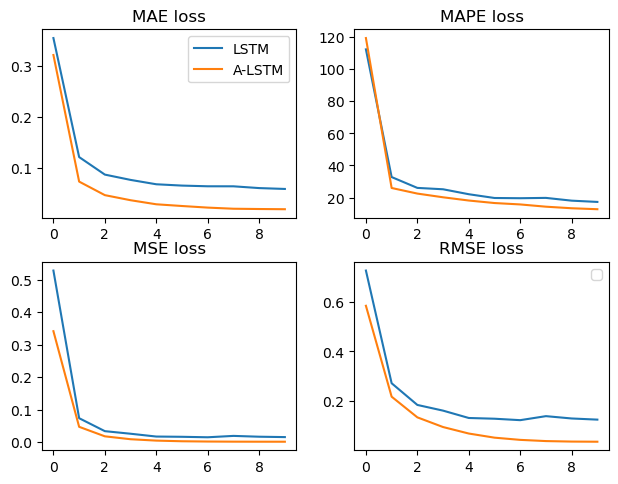

In [285]:
#Result metrics
figure, axis = plt.subplots(2, 2)
figure.tight_layout()
plt.legend()
axis[0, 0].plot(history.history['loss'], label='LSTM')
axis[0, 0].plot(attention_lstm.history['loss'], label='A-LSTM')
axis[0,0].set_title('MAE loss')
axis[1,0].set_title('MSE loss')
axis[0,1].set_title('MAPE loss')
axis[1,1].set_title('RMSE loss')
axis[1, 0].plot(history.history['mse'], label='LSTM')
axis[1, 0].plot(attention_lstm.history['mse'], label='A-LSTM')
axis[0,0].legend()
axis[0, 1].plot(history.history['mape'], label='LSTM')
axis[0, 1].plot(attention_lstm.history['mape'], label='A-LSTM')
axis[1, 1].plot(history.history['root_mean_squared_error'], label='LSTM')
axis[1, 1].plot(attention_lstm.history['root_mean_squared_error'], label='A-LSTM')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


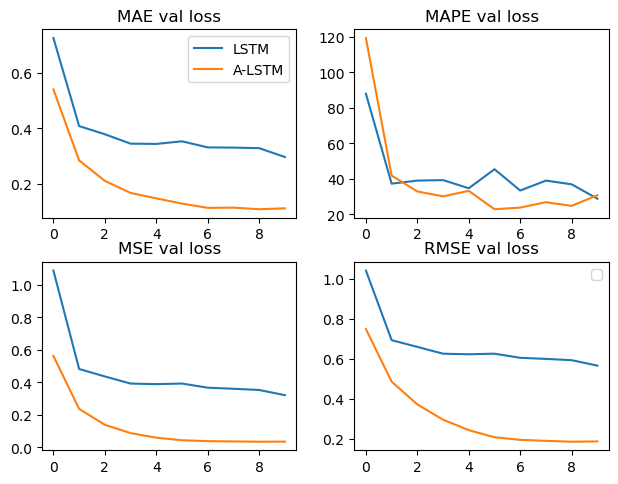

In [286]:
#Result metrics
figure, axis = plt.subplots(2, 2)
figure.tight_layout()
plt.legend()
axis[0, 0].plot(history.history['val_loss'], label='LSTM')
axis[0, 0].plot(attention_lstm.history['val_loss'], label='A-LSTM')
axis[0,0].set_title('MAE val loss')
axis[1,0].set_title('MSE val loss')
axis[0,1].set_title('MAPE val loss')
axis[1,1].set_title('RMSE val loss')
axis[1, 0].plot(history.history['val_mse'], label='LSTM')
axis[1, 0].plot(attention_lstm.history['val_mse'], label='A-LSTM')
axis[0,0].legend()
axis[0, 1].plot(history.history['val_mape'], label='LSTM')
axis[0, 1].plot(attention_lstm.history['val_mape'], label='A-LSTM')
axis[1, 1].plot(history.history['val_root_mean_squared_error'], label='LSTM')
axis[1, 1].plot(attention_lstm.history['val_root_mean_squared_error'], label='A-LSTM')

### Countrywise prediction along the years (Comparitive) -:

In [287]:
s = model2.predict(trainX)
forecast_copies = np.repeat(s, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,26]

forecast_copies = np.repeat(trainY, df_for_training.shape[1], axis=-1)
input_rescale = scaler.inverse_transform(forecast_copies)[:,26]

pred = []
pred2 = []
act = []
take = []
for i in range(10000):
    take.append(i)
    pred.append('A-LSTM prediction')
    pred2.append('LSTM prediction')
    act.append('Actual')
    
s2 = model.predict(trainX)
forecast_copies2 = np.repeat(s2, df_for_training.shape[1], axis=-1)
y_pred_future2 = scaler.inverse_transform(forecast_copies2)[:,26]

209/209 [==============================] - 1s 6ms/step


<AxesSubplot:xlabel='year', ylabel='CO2 emission per capita'>

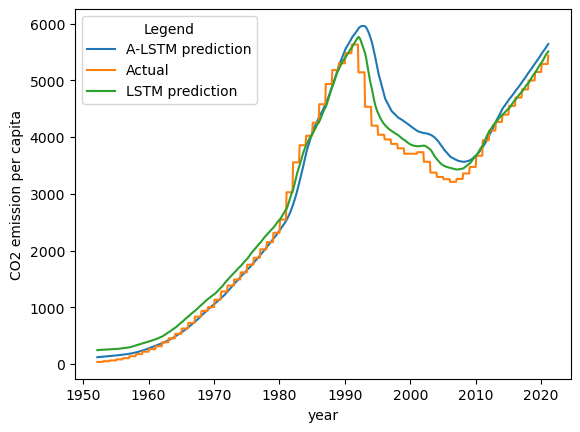

In [288]:
# Afghanistan (1949-2021):
afg_pred = pd.DataFrame({'CO2 emission per capita':y_pred_future[0:828],'Legend':pred[0:828],'year':train_months[37:865]},index=take[0:828])
afg_act = pd.DataFrame({'CO2 emission per capita':input_rescale[0:828],'Legend':act[0:828],'year':train_months[37:865]},index =take[828:1656])
afg_pred2 = pd.DataFrame({'CO2 emission per capita':y_pred_future2[0:828],'Legend':pred2[0:828],'year':train_months[37:865]},index=take[1656:2484])
afg = pd.concat([afg_pred,afg_act,afg_pred2])
sns.lineplot(data = afg, x= 'year',y= 'CO2 emission per capita',hue = 'Legend')

<AxesSubplot:xlabel='year', ylabel='CO2 emission per capita'>

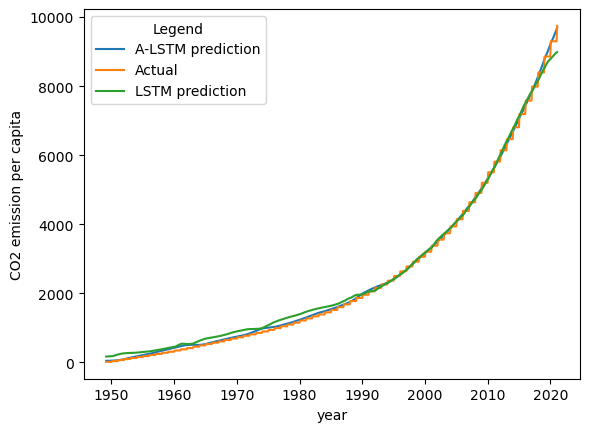

In [289]:
# Bangladesh (1946-2021):
afg_pred = pd.DataFrame({'CO2 emission per capita':y_pred_future[828:1692],'Legend':pred[828:1692],'year':train_months[902:1766]},index=take[0:864])
afg_act = pd.DataFrame({'CO2 emission per capita':input_rescale[828:1692],'Legend':act[828:1692],'year':train_months[902:1766]},index =take[864:1728])
afg_pred2 = pd.DataFrame({'CO2 emission per capita':y_pred_future2[828:1692],'Legend':pred2[828:1692],'year':train_months[902:1766]},index=take[1728:2592])
afg = pd.concat([afg_pred,afg_act,afg_pred2])
sns.lineplot(data = afg, x= 'year',y= 'CO2 emission per capita',hue = 'Legend')

<AxesSubplot:xlabel='year', ylabel='CO2 emission per capita'>

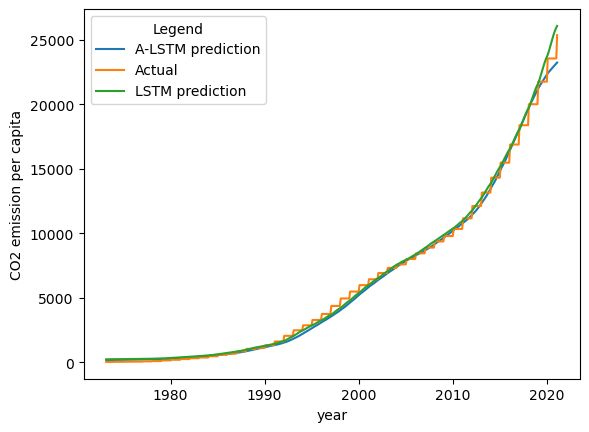

In [290]:
# Bhutan (1970-2021): 
afg_pred = pd.DataFrame({'CO2 emission per capita':y_pred_future[1692:2268],'Legend':pred[1692:2268],'year':train_months[1803:2379]},index=take[0:576])
afg_act = pd.DataFrame({'CO2 emission per capita':input_rescale[1692:2268],'Legend':act[1692:2268],'year':train_months[1803:2379]},index =take[576:1152])
afg_pred2 = pd.DataFrame({'CO2 emission per capita':y_pred_future2[1692:2268],'Legend':pred2[1692:2268],'year':train_months[1803:2379]},index=take[1152:1728])
afg = pd.concat([afg_pred,afg_act,afg_pred2])
sns.lineplot(data = afg, x= 'year',y= 'CO2 emission per capita',hue = 'Legend')

<AxesSubplot:xlabel='year', ylabel='CO2 emission per capita'>

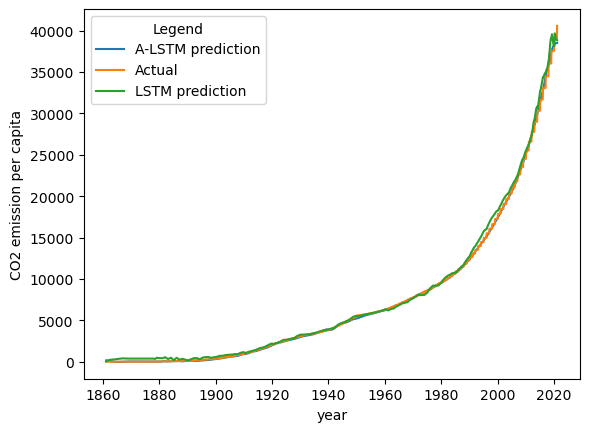

In [291]:
# India (1858-2021): 
afg_pred = pd.DataFrame({'CO2 emission per capita':y_pred_future[2268:4188],'Legend':pred[2268:4188],'year':train_months[2416:4336]},index=take[0:1920])
afg_act = pd.DataFrame({'CO2 emission per capita':input_rescale[2268:4188],'Legend':act[2268:4188],'year':train_months[2416:4336]},index =take[1920:3840])
afg_pred2 = pd.DataFrame({'CO2 emission per capita':y_pred_future2[2268:4188],'Legend':pred2[2268:4188],'year':train_months[2416:4336]},index=take[3840:5760])
afg = pd.concat([afg_pred,afg_act,afg_pred2])
sns.lineplot(data = afg, x= 'year',y= 'CO2 emission per capita',hue = 'Legend')

<AxesSubplot:xlabel='year', ylabel='CO2 emission per capita'>

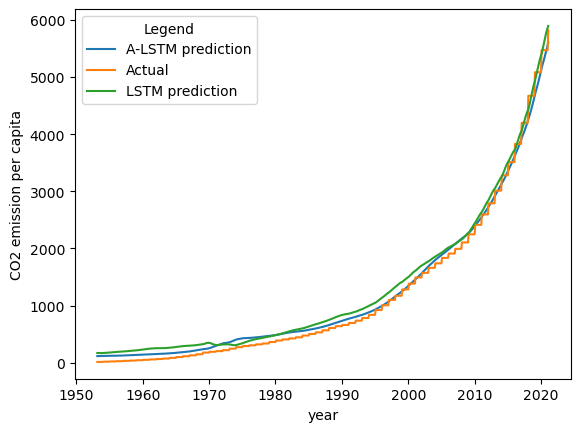

In [292]:
# Nepal (1950-2021): 
afg_pred = pd.DataFrame({'CO2 emission per capita':y_pred_future[4188:5004],'Legend':pred[4188:5004],'year':train_months[4373:5189]},index=take[0:816])
afg_act = pd.DataFrame({'CO2 emission per capita':input_rescale[4188:5004],'Legend':act[4188:5004],'year':train_months[4373:5189]},index =take[816:1632])
afg_pred2 = pd.DataFrame({'CO2 emission per capita':y_pred_future2[4188:5004],'Legend':pred2[4188:5004],'year':train_months[4373:5189]},index=take[1632:2448])
afg = pd.concat([afg_pred,afg_act,afg_pred2])
sns.lineplot(data = afg, x= 'year',y= 'CO2 emission per capita',hue = 'Legend')

<AxesSubplot:xlabel='year', ylabel='CO2 emission per capita'>

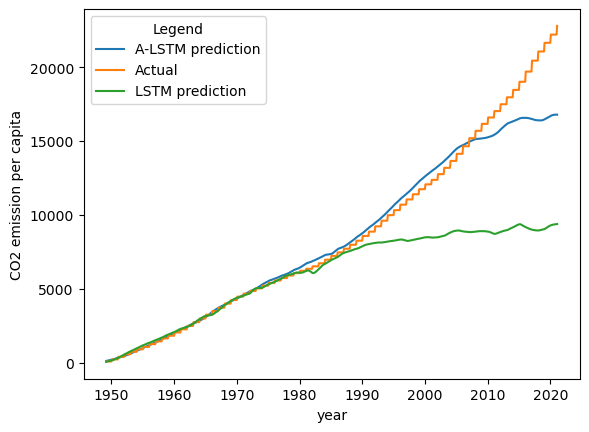

In [293]:
# Pakistan (1946-2021): 
afg_pred = pd.DataFrame({'CO2 emission per capita':y_pred_future[5004:5868],'Legend':pred[5004:5868],'year':train_months[5226:6090]},index=take[0:864])
afg_act = pd.DataFrame({'CO2 emission per capita':input_rescale[5004:5868],'Legend':act[5004:5868],'year':train_months[5226:6090]},index =take[864:1728])
afg_pred2 = pd.DataFrame({'CO2 emission per capita':y_pred_future2[5004:5868],'Legend':pred2[5004:5868],'year':train_months[5226:6090]},index=take[1728:2592])
afg = pd.concat([afg_pred,afg_act,afg_pred2])
sns.lineplot(data = afg, x= 'year',y= 'CO2 emission per capita',hue = 'Legend')

<AxesSubplot:xlabel='year', ylabel='CO2 emission per capita'>

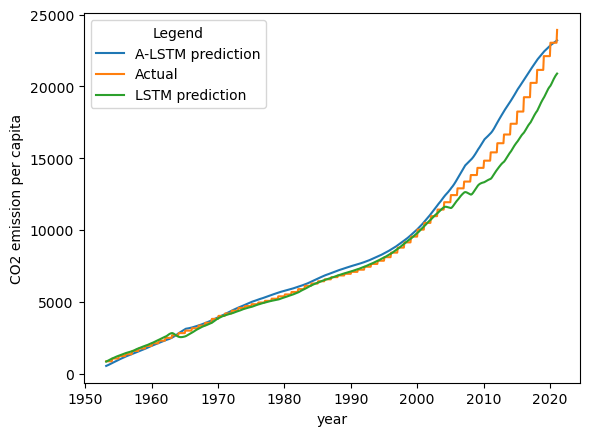

In [294]:
# Sri Lanka (1950-2021): 
afg_pred = pd.DataFrame({'CO2 emission per capita':y_pred_future[5868:6684],'Legend':pred[5868:6684],'year':train_months[6127:6943]},index=take[0:816])
afg_act = pd.DataFrame({'CO2 emission per capita':input_rescale[5868:6684],'Legend':act[5868:6684],'year':train_months[6127:6943]},index =take[816:1632])
afg_pred2 = pd.DataFrame({'CO2 emission per capita':y_pred_future2[5868:6684],'Legend':pred2[5868:6684],'year':train_months[6127:6943]},index=take[1632:2448])
afg = pd.concat([afg_pred,afg_act,afg_pred2])
sns.lineplot(data = afg, x= 'year',y= 'CO2 emission per capita',hue = 'Legend')

In [295]:
# Forecasting

def df_to_X_y(df, window_size=37):
    X = []
    y = []
    for i in range(len(df)-window_size):
        row = [[a] for a in df[i:i+window_size]]
        X.append(row)
        label = df[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)


In [296]:
# Training individual time series to get new values 
#sgd = optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)

for i in range(26):
    X1, y1 = df_to_X_y(df_for_training_scaled[:,i],37)
    model2 = Sequential()
    model2.add(InputLayer((37, 1)))
    model2.add(LSTM(64))
    model2.add(Dense(8, 'relu'))
    model2.add(Dense(1, 'linear'))
    model2.summary()
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]
    model2.compile(optimizer=optimizers.Adam(lr=0.0001, decay=1e-6), loss='mae')
    # fit the model
    history = model2.fit(X1, y1, epochs=5, batch_size=32, verbose=1, callbacks=None)
    #121
    

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_71 (LSTM)              (None, 64)                16896     
                                                                 
 dense_119 (Dense)           (None, 8)                 520       
                                                                 
 dense_120 (Dense)           (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
216/216 [==============================] - 3s 9ms/step - loss: 0.3012
Epoch 2/5
216/216 [==============================] - 2s 9ms/step - loss: 0.0396
Epoch 3/5
216/216 [==============================] - 2s 9ms/step - loss: 0.0170
Epoch 4/5
216/216 [==============================] - 2s 9ms/step - loss: 